## Setup

In [114]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
import json
import numpy as np
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from functions import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

Json Hyper Parameters

In [115]:
# JSON file
f = open ('data/json/input.json', "r")
  # Reading from file
PARAMETERS_ALL = json.loads(f.read())
PARAMETERS = PARAMETERS_ALL["TESTING"]
SPLIT_SIZE = PARAMETERS["SPLIT_SIZE"]

OUTLIER99 = PARAMETERS["OUTLIER99"] 
OUTLIER_ZSCORE = {"STD" : PARAMETERS["OUTLIER_ZSCORE"]["STD"]}
OUTLIER_ZSCORE_IND = PARAMETERS["OUTLIER_ZSCORE_IND"]
OUTLIER_KNN = {"K": PARAMETERS["OUTLIER_KNN"]["K"], "X": PARAMETERS["OUTLIER_KNN"]["X"]}
OUTLIER_DBSCAN = {"K": PARAMETERS["OUTLIER_DBSCAN"]["K"], "X": PARAMETERS["OUTLIER_DBSCAN"]["X"], "EPS": PARAMETERS["OUTLIER_DBSCAN"]["EPS"], "MIN_SAMPLES":  PARAMETERS["OUTLIER_DBSCAN"]["MIN_SAMPLES"]}
OUTLIER_NOISE = {"CV": PARAMETERS["OUTLIER_NOISE"]["CV"], "DEPTH": PARAMETERS["OUTLIER_NOISE"]["DEPTH"], "MULTI": PARAMETERS["OUTLIER_NOISE"]["MULTI"] }

FEATURE_SEL_CORR = {"THRESHOLD_CORR": PARAMETERS["FEATURE_SEL_CORR"]["THRESHOLD"]}

f.close()

#TODO FEATURE
#TODO Regressionmodels
#TODO TESTDATA --> path to csv-file


Get Data from CSV

In [116]:
#Get train Data
df = pd.read_csv("data/csv/house_data_training.csv", sep=';') 
# remove unnamed column
df = df.iloc[:, 1:]
#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])

In [117]:
#Get test Data
NAME_TEST_FILE = "house_data_testing"
df_test_data = pd.read_csv("data/csv/"+NAME_TEST_FILE+".csv", sep=';') 
# remove unnamed column
df_test_data = df_test_data.iloc[:, 1:]
#Transform string to datetime
df_test_data["date"] = pd.to_datetime(df_test_data["date"])

Missing Values

In [118]:
df_test_data = dropMissingValues(df_test_data) 
print("outlier_99")
outlier_list_99 = get99(df_test_data) #TODO Mean for price for trainingsdata
df_test_data = drop99_all(df_test_data, outlier_list_99)
print(green('done'), "\n")

outlier_99
done 



In [119]:
df = dropMissingValues(df) 
print("outlier_99")
outlier_list_99 = get99(df) #TODO Mean for price for trainingsdata
df = drop99_all(df, outlier_list_99)
print(green('done'), "\n")

outlier_99
done 



In [146]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,dis_super,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ahf1,ahf2,ahf3
0,7212650950,2014-07-08,336000.0,4,2.50,2530,8169,2.0,0.0,562.16,...,1993.0,0,98003,47.2634,-122.312,2220,8013,24.658459,108.183999,132.842458
1,3616600250,2014-05-27,1600000.0,3,3.25,3790,19000,2.0,0.0,1462.74,...,1985.0,0,98177,47.7240,-122.373,2740,18628,18.682061,83.213016,101.895077
2,1826049225,2015-04-17,460000.0,4,1.75,1870,8663,1.0,0.0,599.53,...,1949.0,0,98133,47.7366,-122.350,1560,7800,75.078050,101.082827,176.160876
3,1337800830,2015-01-07,998500.0,3,1.75,2140,4800,2.0,0.0,970.84,...,1905.0,0,98112,47.6311,-122.312,2440,4800,49.367640,97.749706,147.117347
4,3062600050,2014-07-14,745000.0,3,2.75,3010,12432,1.0,0.0,1157.55,...,1970.0,0,98052,47.6392,-122.108,2500,12432,43.343635,98.282451,141.626086


##

## Outlier Detection

In [120]:
outlier_dict_all = {}

print('starting z_score')
for p in OUTLIER_ZSCORE["STD"]:
    print(p)
    outlier_list_z_score = z_score(df, p)
    outlier_dict_all["z_score_"+str(p)] = outlier_list_z_score

if OUTLIER_ZSCORE_IND == True:
    outlier_list_z_score_ind = z_score_individual(df)

print(green('done'), '\n\nstarting knn')
for k in OUTLIER_KNN["K"]:
    for o in OUTLIER_KNN["X"]:
        print(k, o)
        outlier_list_knn = outliers_knn(df, k, o, SPLIT_SIZE)
        outlier_dict_all["knn_"+str(k)+"_"+str(o)] = outlier_list_knn

print(green('done'), '\n\nstarting db_scan')
for k in OUTLIER_DBSCAN["K"]:
    for o in OUTLIER_DBSCAN["X"]:
        for e in OUTLIER_DBSCAN["EPS"]:
            for m in OUTLIER_DBSCAN["MIN_SAMPLES"]:
                print(k, o, e, m)
                outlier_list_dbscan = outliers_dbscan(df, k, o, e, m, SPLIT_SIZE)
                outlier_dict_all["db_scan_"+str(k)+"_"+str(o)+"_"+str(e)+"_"+str(m)] = outlier_list_dbscan

print(green('done'), '\n\nstarting noise')
for cv in OUTLIER_NOISE["CV"]:
    for d in OUTLIER_NOISE["DEPTH"]:
        for m in OUTLIER_NOISE["MULTI"]:
            print(cv, d, m)
            outlier_list_noise = getNoise(df, cv, d, m)
            outlier_dict_all["noise_"+str(cv)+"_"+str(d)+"_"+str(m)] = outlier_list_noise

print(green('done'))

starting z_score
10.1
done 

starting knn
done 

starting db_scan
4 500 0.4 8
done 

starting noise
5 5 10
done


## Combinations Outlier / Noise 

In [121]:
outlier_lists_all = list(outlier_dict_all.values())
outlier_lists_keys = list(outlier_dict_all.keys())
combination_list = []
for i, combo in enumerate(getCombinations(outlier_lists_keys), 1):
    if not i == 1: #emtpy tuple
        combination_list.append(combo)
        # print('combo #{}: {}'.format(i, combo))
print("...")
for c in combination_list[10:]:
    print(bold("Combination: "), blue(c),"\n",)
print(bold(len(combination_list)), " total Combinations")

...
7  total Combinations


## Algorythm Selection

### Linear Regression

In [122]:
model_obj_list = []

In [123]:
model_obj_list = []
# for i, c in enumerate(combination_list):
#     print(f'\n{bold(i)}: {blue(c)}')
#     outlier_list = get_unique_list(outlier_dict_all, c)
#     try: 
#         X_train, X_test, y_train, y_test = splitData(df, SPLIT_SIZE, outlier_list, "drop") #TODO drop entfernen
#         model = LinearRegression()
#         obj = Model(model, (X_train, X_test, y_train, y_test), c, df, df.columns.to_list())
#         model_obj_list.append(obj)

#     except Exception as e:
#         print(bold("Error"), red(e))

### Lasso Regression

In [124]:
#model_obj_list = []
for i, c in enumerate(combination_list):
    print(f'\n{bold(i)}: {blue(c)}')
    outlier_list = get_unique_list(outlier_dict_all, c)
    try: 
        X_train, X_test, y_train, y_test = splitData(df, SPLIT_SIZE, outlier_list, "drop")
        df_lasso = train_test_to_df(X_train, X_test, y_train, y_test, df.columns.to_list())
        X_l, y_l = df_lasso.drop(columns=["price", "date", "id"]), df_lasso["price"]
        scaler = StandardScaler().fit(X_l)
        X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size = SPLIT_SIZE, random_state=1) #TODO 
        X_train_l = scaler.transform(X_train_l)
        X_test_l = scaler.transform(X_test_l)
        
        reg = Lasso(alpha=1)
        obj_l = Model(reg, (X_train_l, X_test_l, y_train_l, y_test_l), c, df_lasso, X_l.columns.to_list())
        model_obj_list.append(obj_l)

    except Exception as e:
        print(bold("Error"), red(e))


0: ('z_score_10.1',)
dropped 41 / 53 rows

1: ('db_scan_4_500_0.4_8',)
dropped 3783 / 3783 rows

2: ('noise_5_5_10',)
dropped 35 / 51 rows

3: ('z_score_10.1', 'db_scan_4_500_0.4_8')
dropped 3814 / 3814 rows

4: ('z_score_10.1', 'noise_5_5_10')
dropped 76 / 76 rows

5: ('db_scan_4_500_0.4_8', 'noise_5_5_10')
dropped 3808 / 3808 rows

6: ('z_score_10.1', 'db_scan_4_500_0.4_8', 'noise_5_5_10')
dropped 3839 / 3839 rows


In [125]:
#Summary
df_summary = pd.DataFrame(columns=['model', 'combo', 'mae', 'score'])
for o in model_obj_list:
    o.train()
    mae, score = o.summary()
    comb = o.get_comb()
    row = {'model': o.get_model(), 'combo': comb, 'mae': mae, 'score': score}
    df_summary = df_summary.append(row, ignore_index=True)

df_summary.sort_values("mae")

,model,combo,mae,score
5,Lasso(alpha=1),"(db_scan_4_500_0.4_8, noise_5_5_10)",100320.58,0.677609
6,Lasso(alpha=1),"(z_score_10.1, db_scan_4_500_0.4_8, noise_5_5_10)",103119.48,0.692954
3,Lasso(alpha=1),"(z_score_10.1, db_scan_4_500_0.4_8)",103535.6,0.687422
1,Lasso(alpha=1),"(db_scan_4_500_0.4_8,)",105591.52,0.6705
0,Lasso(alpha=1),"(z_score_10.1,)",126719.23,0.689306
4,Lasso(alpha=1),"(z_score_10.1, noise_5_5_10)",128032.28,0.676241
2,Lasso(alpha=1),"(noise_5_5_10,)",128608.33,0.675208


In [126]:
mae_best = df_summary[df_summary.mae==df_summary.mae.min()]
#score_best = df_summary[df_summary.score==df_summary.score.max()]
best_model_obj = getBestModel(model_obj_list, df_summary, mae_best.index[0])
print(best_model_obj)
#rint(f'{bold("Lowest mae:")} {mae_best}')

Model: Lasso(alpha=1) Combination: ('db_scan_4_500_0.4_8', 'noise_5_5_10') Features: 22


In [127]:
X_train, X_test, y_train, y_test = best_model_obj.get_data()

df_test =  train_test_to_df(X_train, X_test, y_train, y_test,best_model_obj.get_features())

df_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,dis_super,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ahf1,ahf2,ahf3,price
0,0.846881,2.045170,1.362121,-0.194248,0.926698,-0.056309,0.878616,-0.181613,-0.604372,0.406741,...,-0.119316,1.459420,-0.832892,-0.875961,1.539933,-0.168457,-0.389593,0.523668,-0.079872,600600.0
1,-0.357813,-0.419883,-0.632031,-0.042883,0.926698,-0.056309,-0.556745,-0.181613,-0.604372,-0.530558,...,-0.119316,-1.202982,1.501553,-0.052853,-0.044456,-0.000974,0.246870,-0.981943,-0.272403,375000.0
2,0.846881,0.636568,0.186996,-0.197279,0.926698,-0.056309,1.380290,-0.181613,-0.604372,-0.530558,...,-0.119316,-0.833744,-1.339310,0.201563,0.300659,-0.195476,-0.307509,0.825083,0.141536,275000.0
3,0.846881,-0.067733,-0.430242,-0.192955,-0.915226,-0.056309,-1.047273,-0.181613,-0.604372,-0.530558,...,-0.119316,-1.358451,-1.992026,-0.763719,-0.091517,-0.166796,-1.222073,-0.531708,-1.330880,280000.0
4,0.846881,0.636568,1.302772,-0.268172,0.926698,-0.056309,-0.742140,-0.181613,-0.604372,1.344040,...,-0.119316,-0.270170,-0.097180,0.171631,1.477185,-0.272380,-1.088810,-0.516972,-1.207239,710000.0


## Feature Selection

In [128]:
model_obj_list_best = [best_model_obj]
X_train, X_test, y_train, y_test = best_model_obj.get_data()

df_feature_reduction = train_test_to_df(X_train, X_test, y_train, y_test, best_model_obj.get_features())
#print(df_feature_reduction)

for threshold in FEATURE_SEL_CORR["THRESHOLD_CORR"]:
    #print(threshold, type(threshold))
    try: 
        rel_features = getRelFeatures(df_feature_reduction, threshold)
        #print(len(rel_features), rel_features)
        df_feature_reduction = df_feature_reduction[rel_features]
        X_train, X_test, y_train, y_test = splitData(df_feature_reduction, SPLIT_SIZE)
        best_model_obj_new = Model(best_model_obj.get_model(), (X_train, X_test, y_train, y_test), best_model_obj.get_comb() , df_feature_reduction, df_feature_reduction.columns.to_list())
        model_obj_list_best.append(best_model_obj_new)

    except Exception as e:
        print(bold("Error"), red(e))

##manual feature selection
rel_features_m = []

for m in model_obj_list_best:
    print(m)

Model: Lasso(alpha=1) Combination: ('db_scan_4_500_0.4_8', 'noise_5_5_10') Features: 23


In [129]:
#Summary
df_summary_best = pd.DataFrame(columns=['model', 'combo', 'mae', 'score', 'features'])
for i, o in enumerate(model_obj_list_best):
    print(i)
    #print(f'{o.get_type()}, {o.get_comb()}')
    o.train()
    mae, score = o.summary()
    comb = o.get_comb()
    features = o.get_features()
    if "price" in features:
        features.remove("price")
    row = {'model': o.get_model(),'combo': comb, 'mae': mae, 'score': score, 'features': len(features), 'index':int(i)}
    df_summary_best = df_summary_best.append(row, ignore_index=True)
    i +=1


df_summary_best.sort_values("mae")

0


,model,combo,mae,score,features,index
0,Lasso(alpha=1),"(db_scan_4_500_0.4_8, noise_5_5_10)",100320.58,0.677609,22,0.0


## Select Best Model

## Testdata

In [130]:
model_obj = model_obj_list_best[0]

#set new test Data
X_train, X_test, y_train, y_test = model_obj.get_data()
#print(type(X_test), type(y_test))
X_test, y_test = df_test_data.drop(columns=["price", "date", "id"]), df_test_data["price"]
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)
model_obj.set_data(X_train, X_test, y_train, y_test)
#Train Model
model_obj.train()
mae, score = model_obj.summary()
predictions = model_obj.pred()


df_test_data["price_pred"]  = predictions
df_test_data["diff"] = df_test_data["price"]  - df_test_data["price_pred"]  
df_test_data.loc[:, ["price", "price_pred", "diff"]]


,price,price_pred,diff
0,336000.0,3.357004e+05,299.648274
1,1600000.0,1.208792e+06,391208.346728
2,460000.0,5.365475e+05,-76547.544713
3,998500.0,6.856469e+05,312853.126935
4,745000.0,6.783333e+05,66666.691522
...,...,...,...
609,739000.0,5.860355e+05,152964.464450
610,710000.0,6.399387e+05,70061.271402
611,475000.0,5.803427e+05,-105342.716958
612,340000.0,4.510676e+05,-111067.615138


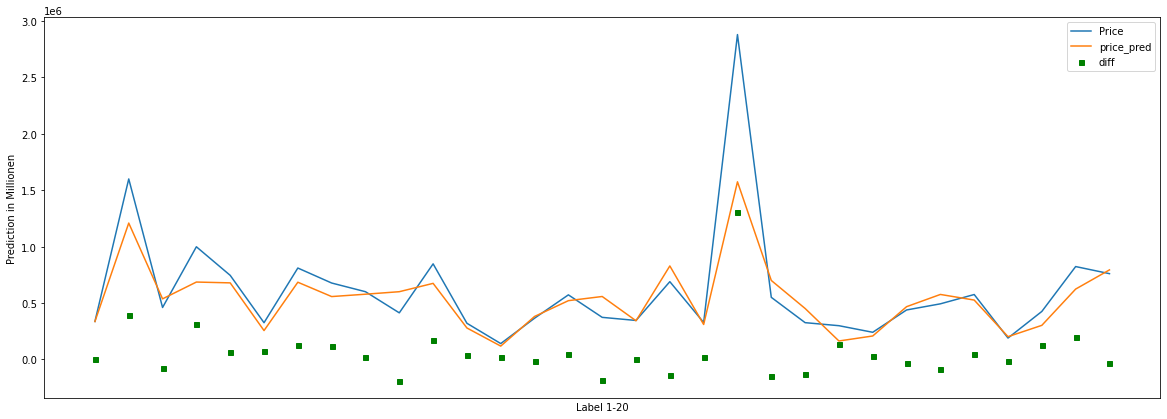

In [145]:
plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 30
real = df_test_data.loc[:x, "price"]
pred = df_test_data.loc[:x,"price_pred"]
diff = df_test_data.loc[:x,"diff"]

plt.plot(real, label="Price")
plt.plot(pred, label="price_pred")
plt.plot(diff, "gs", ms=5, label="diff")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("Label 1-20")
plt.legend(loc="best")

plt.show()

In [131]:
#df_test_data[["price", "price_pred"]].describe()
df_test_data.loc[:, ["price", "price_pred", "diff"]].describe()

,price,price_pred,diff
count,5.970000e+02,5.970000e+02,5.970000e+02
mean,5.243022e+05,4.772169e+05,4.708534e+04
std,3.200201e+05,2.353074e+05,1.891774e+05
min,1.750000e+04,-1.729781e+05,-6.425245e+05
25%,3.321000e+05,3.216623e+05,-3.831222e+04
50%,4.654250e+05,4.577374e+05,3.569900e+04
75%,6.250000e+05,6.016373e+05,1.090798e+05
max,2.950000e+06,1.574697e+06,1.873987e+06


In [132]:
#TODO sqft_living wenn price auffällig niedrig obwohl m² hoch clsuter
#TODO PCA macht warscheinlich wenig sinn